In [24]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import yfinance as yf 
from datetime import date

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Reproducibility
SEED = 42
np.random.seed(SEED)

In [25]:
from datetime import date

symbol = "AAPL"                           # Stock ticker
start = "2006-01-01"
end = date.today().strftime("%Y-%m-%d")   # today's date in YYYY-MM-DD format

# Predict the next-day return
TARGET = "Target_Return_1d"

# Define test period (time-based split)
test_start_date = "2024-01-01"


In [26]:
df = yf.download(symbol, start=start, end=end)
df.index.name = "Date"  # ensure a clean datetime index

df.head()


/var/folders/n8/k6s3cgwn5gv4p4x929qsxlkc0000gn/T/ipykernel_42095/1416540064.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2006-01-03,2.241831,2.241831,2.166854,2.170752,807234400
2006-01-04,2.248428,2.278719,2.234332,2.253226,619603600
2006-01-05,2.230735,2.246330,2.211841,2.244231,449422400
2006-01-06,2.288317,2.300314,2.235833,2.256827,704457600
2006-01-09,2.280818,2.315308,2.271521,2.301212,675040800


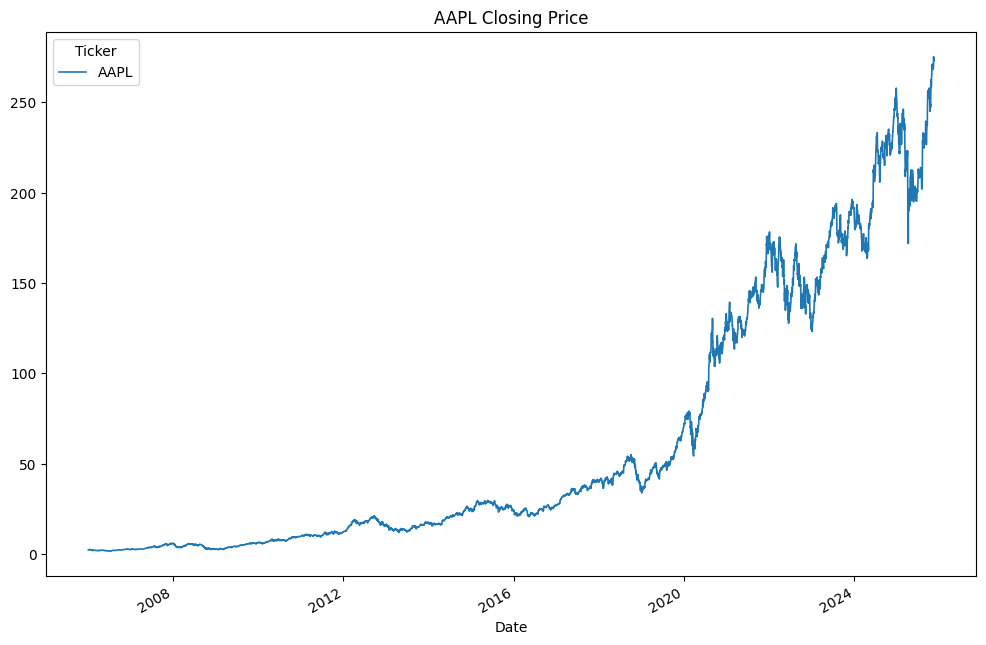

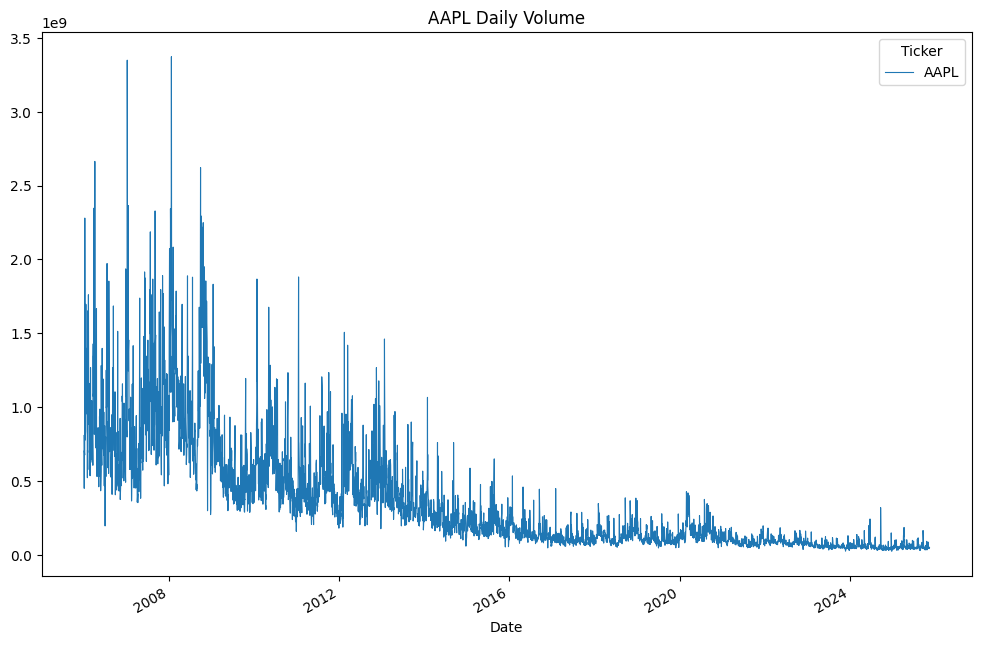

In [27]:
# ---------- 4) EDA: PRICE & VOLUME ----------
# Close over time
df["Close"].plot(title=f"{symbol} Closing Price", linewidth=1.2, figsize=(12,8))
plt.show()

# Volume over time
df["Volume"].plot(title=f"{symbol} Daily Volume",  linewidth=0.8, figsize=(12,8))
plt.show()


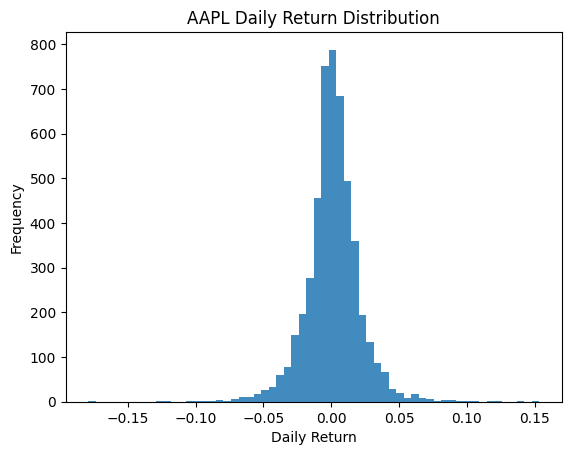

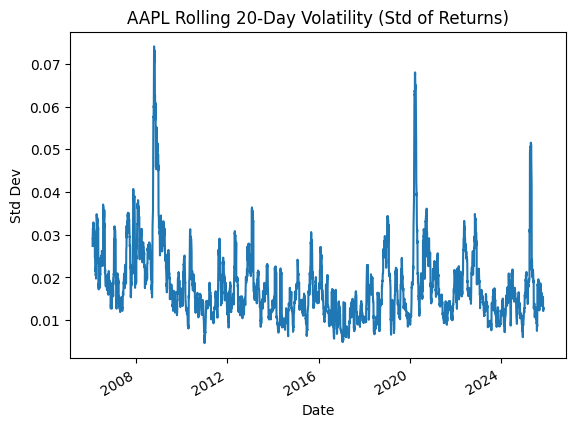

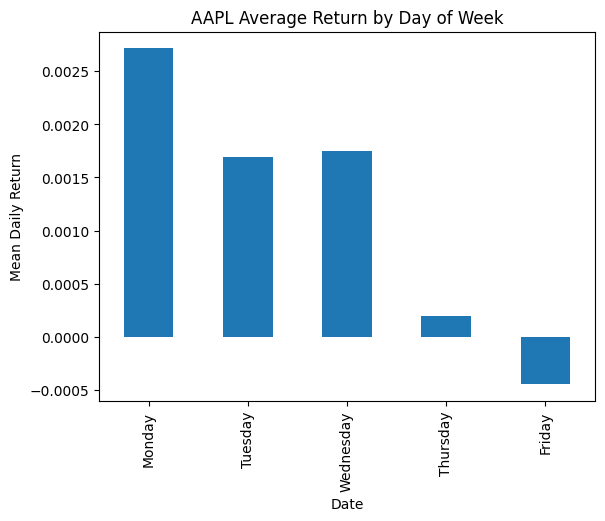

In [28]:
# --- Make sure columns are flat (handles yfinance-style MultiIndex) ---
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [c[0] if isinstance(c, tuple) else c for c in df.columns]

# --- Returns as a proper Series ---
ret = df["Close"].pct_change().dropna()    # 1D Series indexed by Date

# --- Distribution of daily returns ---
ret.plot(kind="hist", bins=60, alpha=0.85, title=f"{symbol} Daily Return Distribution")
plt.xlabel("Daily Return")
plt.show()

# --- Rolling 20-day volatility ---
ret.rolling(20).std().plot(title=f"{symbol} Rolling 20-Day Volatility (Std of Returns)")
plt.ylabel("Std Dev")
plt.show()

# --- Day-of-week behavior ---
dow_order = ["Monday","Tuesday","Wednesday","Thursday","Friday"]
ret.groupby(ret.index.day_name()).mean().reindex(dow_order).plot(
    kind="bar", title=f"{symbol} Average Return by Day of Week"
)
plt.ylabel("Mean Daily Return")
plt.show()


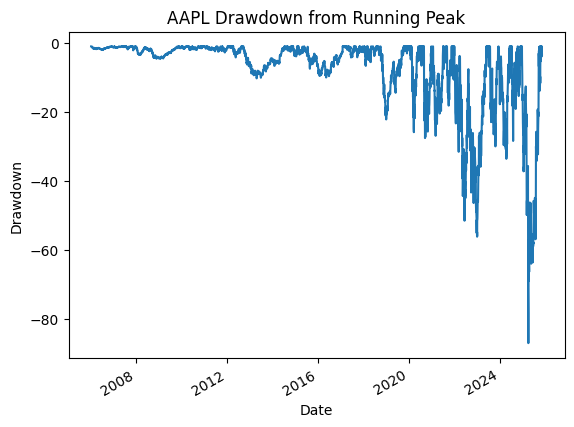

Max Drawdown: -8702.13%


In [29]:
close = df["Close"].copy()
running_peak = close.cummax()
drawdown = (close - running_peak) - 1.0

drawdown.plot(title=f"{symbol} Drawdown from Running Peak")
plt.ylabel("Drawdown")
plt.show()

print(f"Max Drawdown: {drawdown.min():.2%}")

In [30]:
def compute_rsi(close: pd.Series, window=14):
    """  
    Wilder's RSI Heuristic zones: >70 = overbought, <30 = oversold
    """
    delta = close.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.rolling(window).mean()
    roll_down = down.rolling(window).mean()
    rs = roll_up / (roll_down + 1e-9)
    return 100 - (100 / (1 + rs))

def compute_macd(close: pd.Series, fast=12, slow=26, signal=9):
    """
    MACD = EMA(fast) - EMA(slow); plus signal line and histogram.
    """
    ema_fast = close.ewm(span=fast, adjust=False).mean()
    ema_slow = close.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    hist = macd - signal_line
    return macd, signal_line, hist

In [31]:
# ---------- 8) FEATURE ENGINEERING (using Close) ----------
df_feat = df.copy()

# Basic returns based on Close
df_feat["Return_1d"] = df_feat["Close"].pct_change()
df_feat["LogReturn_1d"] = np.log1p(df_feat["Return_1d"])

# Rolling means & rolling volatility (past-only windows)
df_feat["MA_5"]   = df_feat["Close"].rolling(5).mean()
df_feat["MA_10"]  = df_feat["Close"].rolling(10).mean()
df_feat["MA_20"]  = df_feat["Close"].rolling(20).mean()
df_feat["Vol_10"] = df_feat["Return_1d"].rolling(10).std()
df_feat["Vol_20"] = df_feat["Return_1d"].rolling(20).std()

# Momentum indicators computed on Close
df_feat["RSI_14"] = compute_rsi(df_feat["Close"], 14)
macd, macd_sig, macd_hist = compute_macd(df_feat["Close"])
df_feat["MACD"] = macd
df_feat["MACD_Signal"] = macd_sig
df_feat["MACD_Hist"] = macd_hist

# Lagged returns to avoid look-ahead leakage
for k in [1,2,3,5,10]:
    df_feat[f"Return_1d_lag{k}"] = df_feat["Return_1d"].shift(k)

# Target = NEXT-DAY return (shift backward)
TARGET = "Target_Return_1d"
df_feat[TARGET] = df_feat["Return_1d"].shift(-1)

# Drop NaNs introduced by rolling/shift
df_feat = df_feat.dropna()

df_feat.head()


,Close,High,Low,Open,Volume,Return_1d,LogReturn_1d,MA_5,MA_10,MA_20,...,RSI_14,MACD,MACD_Signal,MACD_Hist,Return_1d_lag1,Return_1d_lag2,Return_1d_lag3,Return_1d_lag5,Return_1d_lag10,Target_Return_1d
Date,,,,,,,,,,,,,,,,,,,,,
2006-02-01,2.261925,2.293116,2.238532,2.247830,521186400,-0.001192,-0.001192,2.221076,2.259315,2.334608,...,30.709877,-0.015802,0.003582,-0.019384,0.006800,0.041233,-0.004148,-0.024198,-0.026207,-0.044020
2006-02-02,2.162354,2.260125,2.160854,2.252327,707322000,-0.044020,-0.045019,2.219697,2.238501,2.330304,...,25.532043,-0.023987,-0.001932,-0.022055,-0.001192,0.006800,0.041233,-0.025202,-0.041823,-0.003467
2006-02-03,2.154857,2.183049,2.130564,2.166553,692123600,-0.003467,-0.003473,2.218617,2.225785,2.326510,...,21.207129,-0.030725,-0.007690,-0.023034,-0.044020,-0.001192,0.006800,-0.004148,-0.037323,-0.063327
2006-02-06,2.018397,2.174651,2.001602,2.159955,1651767600,-0.063327,-0.065421,2.172431,2.194685,2.313014,...,18.380059,-0.046539,-0.015460,-0.031079,-0.003467,-0.044020,-0.001192,0.041233,0.020765,0.004458
2006-02-07,2.027395,2.083778,1.999803,2.047488,1388830800,0.004458,0.004448,2.124986,2.169372,2.300343,...,20.929445,-0.057681,-0.023904,-0.033777,-0.063327,-0.003467,-0.044020,0.006800,-0.020986,0.017900


In [32]:
# --- Directional target (1 = next day up) ---
df_feat["Target_Up"] = (df_feat["Target_Return_1d"] > 0).astype(int)

# --- Extra indicators (quick wins) ---
low14  = df_feat["Low"].rolling(14).min()
high14 = df_feat["High"].rolling(14).max()
df_feat["Stoch_%K"] = 100 * (df_feat["Close"] - low14) / (high14 - low14)
df_feat["Stoch_%D"] = df_feat["Stoch_%K"].rolling(3).mean()
df_feat["Williams_%R"] = -100 * (high14 - df_feat["Close"]) / (high14 - low14)

obv = (np.sign(df_feat["Return_1d"]).fillna(0) * df_feat["Volume"]).fillna(0)
df_feat["OBV"] = obv.cumsum()

# calendar features (no leakage)
df_feat["DOW_sin"]   = np.sin(2*np.pi*df_feat.index.dayofweek/7)
df_feat["DOW_cos"]   = np.cos(2*np.pi*df_feat.index.dayofweek/7)
df_feat["Month_sin"] = np.sin(2*np.pi*df_feat.index.month/12)
df_feat["Month_cos"] = np.cos(2*np.pi*df_feat.index.month/12)

# keep things clean after new rollings
df_feat = df_feat.dropna().copy()


In [33]:
# ---------- 8) FEATURE ENGINEERING (lean, leak-safe, efficient) ----------
df_feat = df.copy()

# --- A) Robust setup for long histories (2006+) ---
df_feat = df_feat.sort_index()
df_feat = df_feat[~df_feat.index.duplicated(keep="first")]

# Use adjusted close to remove splits/dividends
if "Adj Close" in df_feat.columns:
    df_feat["Close"] = pd.to_numeric(df_feat["Adj Close"], errors="coerce")
else:
    df_feat["Close"] = pd.to_numeric(df_feat["Close"], errors="coerce")

# Ensure numeric volume
if "Volume" in df_feat.columns:
    df_feat["Volume"] = pd.to_numeric(df_feat["Volume"], errors="coerce")

# --- B) Helper functions ---
def rsi(series: pd.Series, period=14) -> pd.Series:
    delta = series.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()
    rs = avg_gain / avg_loss.replace(0, np.nan)
    return (100 - (100 / (1 + rs))).fillna(50.0)

def macd_hist(series: pd.Series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    return (macd_line - signal_line).fillna(0.0)

# --- C) Core returns & trend ---
df_feat["Return_1d"]    = df_feat["Close"].pct_change()
df_feat["Return_1d_lag1"] = df_feat["Return_1d"].shift(1)
df_feat["Return_1d_lag2"] = df_feat["Return_1d"].shift(2)

# 20-day moving average & distance to trend
df_feat["MA_20"] = df_feat["Close"].rolling(20, min_periods=20).mean()
df_feat["Price_vs_MA20"] = df_feat["Close"] / df_feat["MA_20"] - 1
df_feat["MA_50"] = df_feat["Close"].rolling(50, min_periods=50).mean()
df_feat["Price_vs_MA50"] = df_feat["Close"] / df_feat["MA_50"] - 1
df_feat["MA_200"] = df_feat["Close"].rolling(200, min_periods=20).mean()
df_feat["Price_vs_MA200"] = df_feat["Close"] / df_feat["MA_200"] - 1

# --- D) Volatility (20-day) ---
df_feat["Vol_10"] = df_feat["Return_1d"].rolling(10, min_periods=10).std()
df_feat["Vol_20"] = df_feat["Return_1d"].rolling(20, min_periods=20).std()

# --- E) Indicators (RSI, MACD histogram, Bollinger %B + Width) ---
df_feat["RSI_14"] = rsi(df_feat["Close"], 14)

macd_hist_vals = macd_hist(df_feat["Close"])
df_feat["MACD_Hist"] = macd_hist_vals

ma20  = df_feat["MA_20"]
std20 = df_feat["Close"].rolling(20, min_periods=20).std()
upper = ma20 + 2 * std20
lower = ma20 - 2 * std20
df_feat["BB_PctB_20_2"]  = (df_feat["Close"] - lower) / (upper - lower)
df_feat["BB_Width_20_2"] = (upper - lower) / ma20.replace(0, np.nan)

# --- F) Target: next-day return ---
TARGET = "Target_Return_1d"
df_feat[TARGET] = df_feat["Return_1d"].shift(-1)

# --- G) Cleanup ---
df_feat = df_feat.dropna().copy()

print("Feature engineering complete. Columns:", df_feat.columns.tolist())
df_feat.head()

Feature engineering complete. Columns: ['Close', 'High', 'Low', 'Open', 'Volume', 'Return_1d', 'Return_1d_lag1', 'Return_1d_lag2', 'MA_20', 'Price_vs_MA20', 'MA_50', 'Price_vs_MA50', 'MA_200', 'Price_vs_MA200', 'Vol_10', 'Vol_20', 'RSI_14', 'MACD_Hist', 'BB_PctB_20_2', 'BB_Width_20_2', 'Target_Return_1d']


,Close,High,Low,Open,Volume,Return_1d,Return_1d_lag1,Return_1d_lag2,MA_20,Price_vs_MA20,...,Price_vs_MA50,MA_200,Price_vs_MA200,Vol_10,Vol_20,RSI_14,MACD_Hist,BB_PctB_20_2,BB_Width_20_2,Target_Return_1d
Date,,,,,,,,,,,,,,,,,,,,,
2006-03-15,1.986307,2.040591,1.965013,2.030694,891996000,-0.016192,0.024970,0.039405,2.044489,-0.028458,...,-0.081998,2.163728,-0.081998,0.024156,0.021886,43.947141,0.000496,0.312704,0.151943,-0.028990
2006-03-16,1.928723,2.006400,1.928423,2.004900,749638400,-0.028990,-0.016192,0.024970,2.037127,-0.053214,...,-0.106024,2.159120,-0.106709,0.024980,0.021971,39.785828,-0.001093,0.167102,0.159851,0.005443
2006-03-17,1.939221,1.965612,1.922725,1.941920,812042000,0.005443,-0.028990,-0.016192,2.028264,-0.043901,...,-0.098574,2.154891,-0.100084,0.024263,0.021416,40.884765,-0.000893,0.228403,0.161642,-0.010361
2006-03-20,1.919128,1.963214,1.915528,1.956017,605441200,-0.010361,0.005443,-0.028990,2.018817,-0.049380,...,-0.105322,2.150443,-0.107566,0.022255,0.021461,39.402452,-0.001533,0.200310,0.164771,-0.034068
2006-03-21,1.853746,1.929623,1.841150,1.853746,1345366400,-0.034068,-0.010361,0.005443,2.007915,-0.076781,...,-0.132287,2.144948,-0.135762,0.023676,0.022302,34.960707,-0.005553,0.071143,0.179036,-0.002264


Using 10 features: ['Return_1d', 'Return_1d_lag1', 'Return_1d_lag2', 'MA_20', 'Price_vs_MA20', 'Vol_20', 'RSI_14', 'MACD_Hist', 'BB_PctB_20_2', 'BB_Width_20_2']


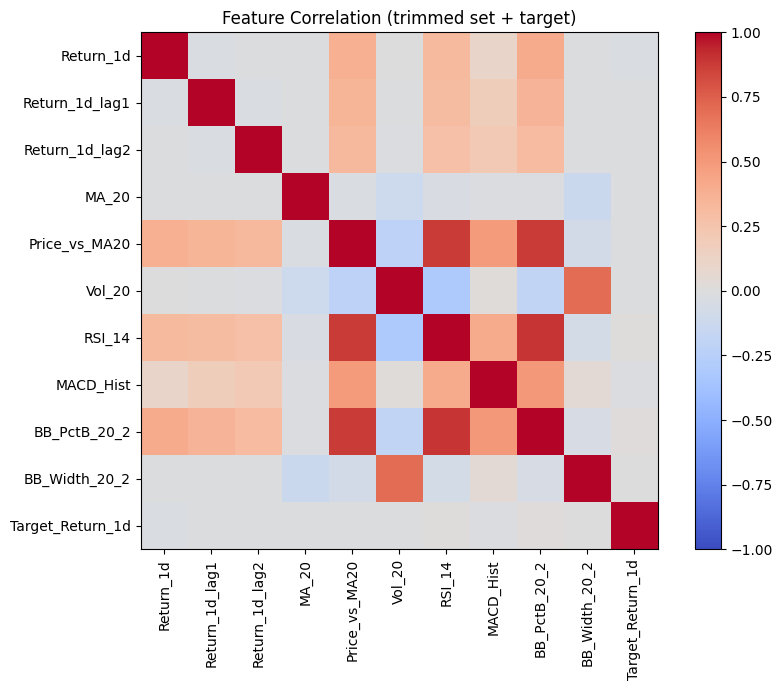

In [34]:
# ---------- 9) CORRELATIONS (trimmed, de-collinear feature set) ----------
# Hand-picked core features: low redundancy, broad signal coverage
proposed_features = [
    # momentum
    "Return_1d", "Return_1d_lag1", "Return_1d_lag2",
    # trend
    "MA_20", "Price_vs_MA20",
    # volatility
    "Vol_20",
    # oscillators / bands
    "RSI_14", "MACD_Hist", "BB_PctB_20_2", "BB_Width_20_2",
]

# Keep only features that actually exist (safety)
features = [f for f in proposed_features if f in df_feat.columns]
dropped = [f for f in proposed_features if f not in df_feat.columns]
print(f"Using {len(features)} features:", features)
if dropped:
    print("Skipped (not found):", dropped)

# Correlation matrix including target
corr = df_feat[features + [TARGET]].corr()

# Heatmap using matplotlib (no seaborn)
plt.figure(figsize=(10, 7))
im = plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Feature Correlation (trimmed set + target)")
plt.tight_layout()
plt.show()


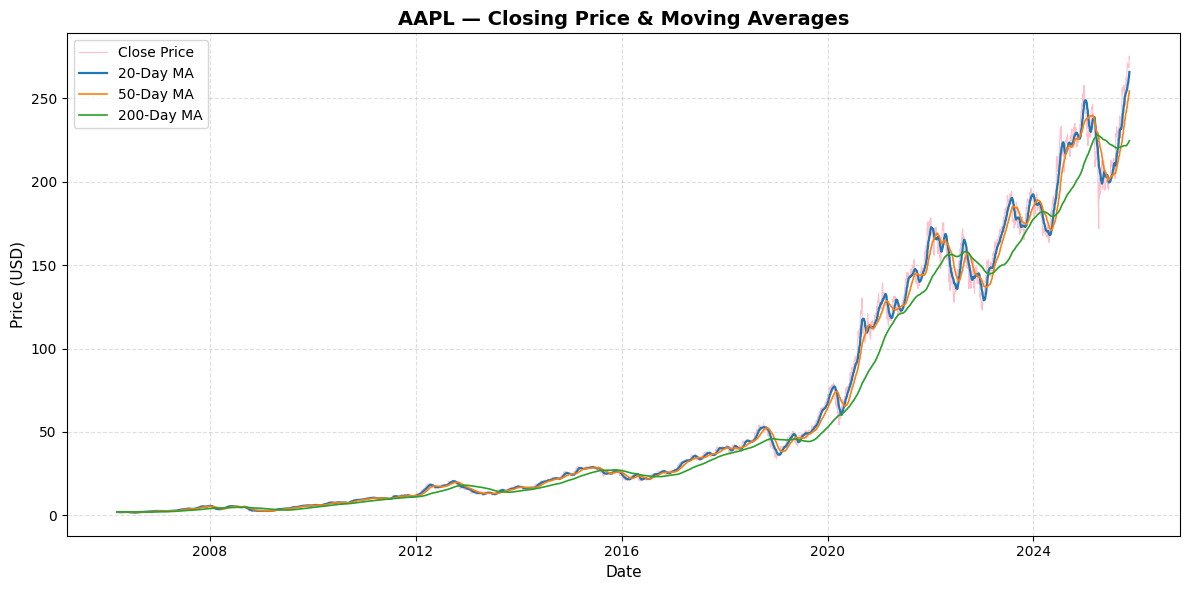

In [35]:
# ---------- Visualization: Closing Price with Moving Averages ----------
plt.figure(figsize=(12, 6))

# --- Plot Close and key MAs ---
plt.plot(df_feat.index, df_feat["Close"], label="Close Price", linewidth=0.8, color="pink")
plt.plot(df_feat.index, df_feat["MA_20"], label="20-Day MA", linewidth=1.6)
plt.plot(df_feat.index, df_feat["MA_50"], label="50-Day MA", linewidth=1.2)
plt.plot(df_feat.index, df_feat["MA_200"],label="200-Day MA",linewidth=1.2)

# --- Styling ---
plt.title(f"{symbol} — Closing Price & Moving Averages", fontsize=14, weight="bold")
plt.xlabel("Date", fontsize=11)
plt.ylabel("Price (USD)", fontsize=11)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(loc="upper left", fontsize=10)
plt.tight_layout()
plt.show()


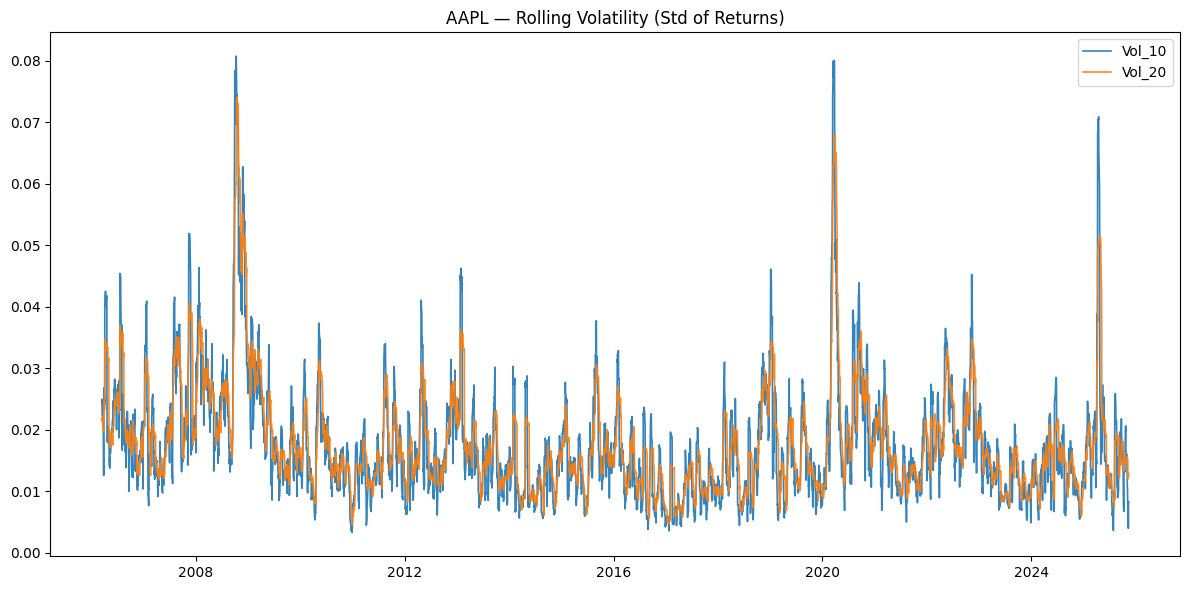

In [36]:
plt.figure(figsize=(12,6))
plt.plot(df_feat["Vol_10"], label="Vol_10", alpha=0.9, linewidth=1.2)
plt.plot(df_feat["Vol_20"], label="Vol_20", alpha=0.9, linewidth=1.2)
plt.title(f"{symbol} — Rolling Volatility (Std of Returns)")
plt.legend(); plt.tight_layout(); plt.show()

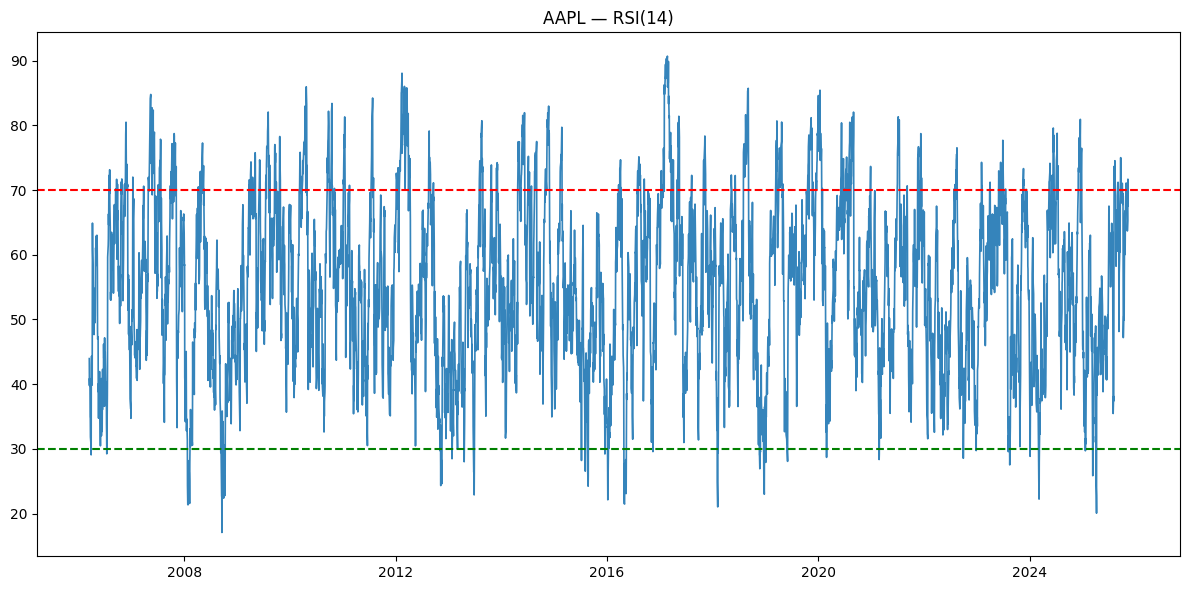

In [37]:
plt.figure(figsize=(12,6))
plt.plot(df_feat["RSI_14"], alpha=0.9, linewidth=1.2)
plt.axhline(70, color="r", linestyle="--", linewidth=1.5)
plt.axhline(30, color="g", linestyle="--", linewidth=1.5)
plt.title(f"{symbol} — RSI(14)")
plt.tight_layout(); plt.show()

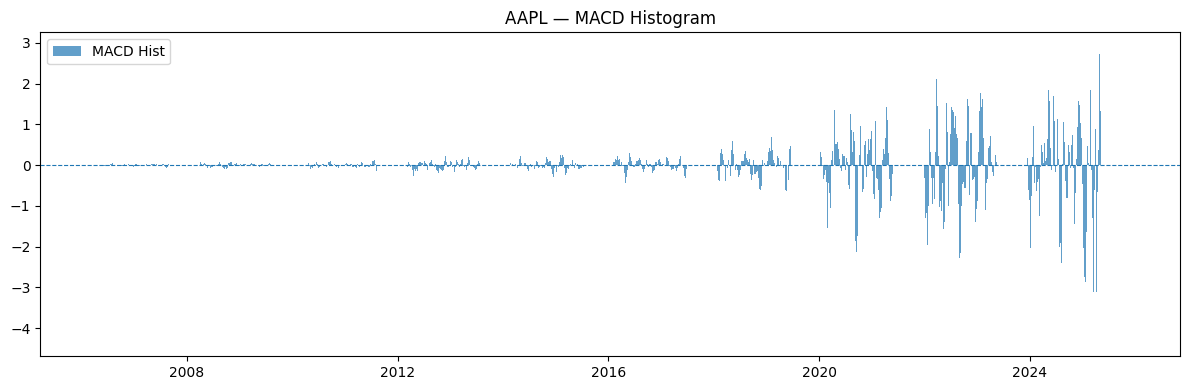

In [38]:
# Plot only histogram (no MACD or Signal lines)
plt.figure(figsize=(12,4))
plt.bar(df_feat.index, df_feat["MACD_Hist"], label="MACD Hist", alpha=0.7, width=1.0)
plt.axhline(0, linestyle="--", linewidth=0.8)
plt.title(f"{symbol} — MACD Histogram")
plt.legend(); plt.tight_layout(); plt.show()

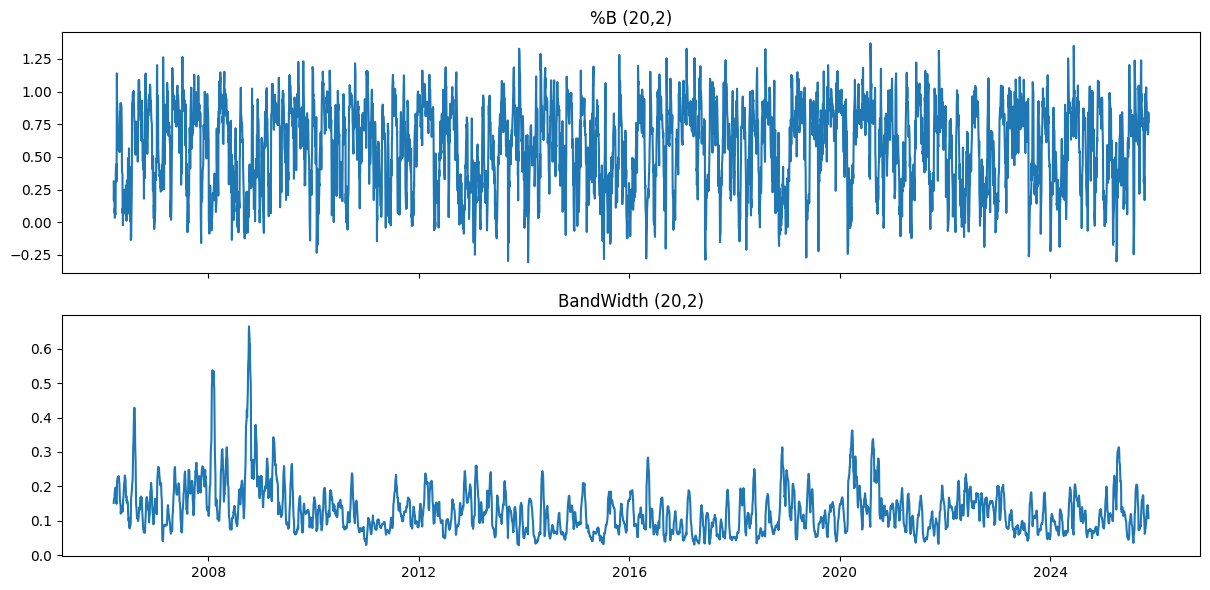

In [39]:
fig, ax = plt.subplots(2,1, figsize=(12,6), sharex=True)
ax[0].plot(df_feat["BB_PctB_20_2"]); ax[0].set_title("%B (20,2)")
ax[1].plot(df_feat["BB_Width_20_2"]); ax[1].set_title("BandWidth (20,2)")
plt.tight_layout(); plt.show()

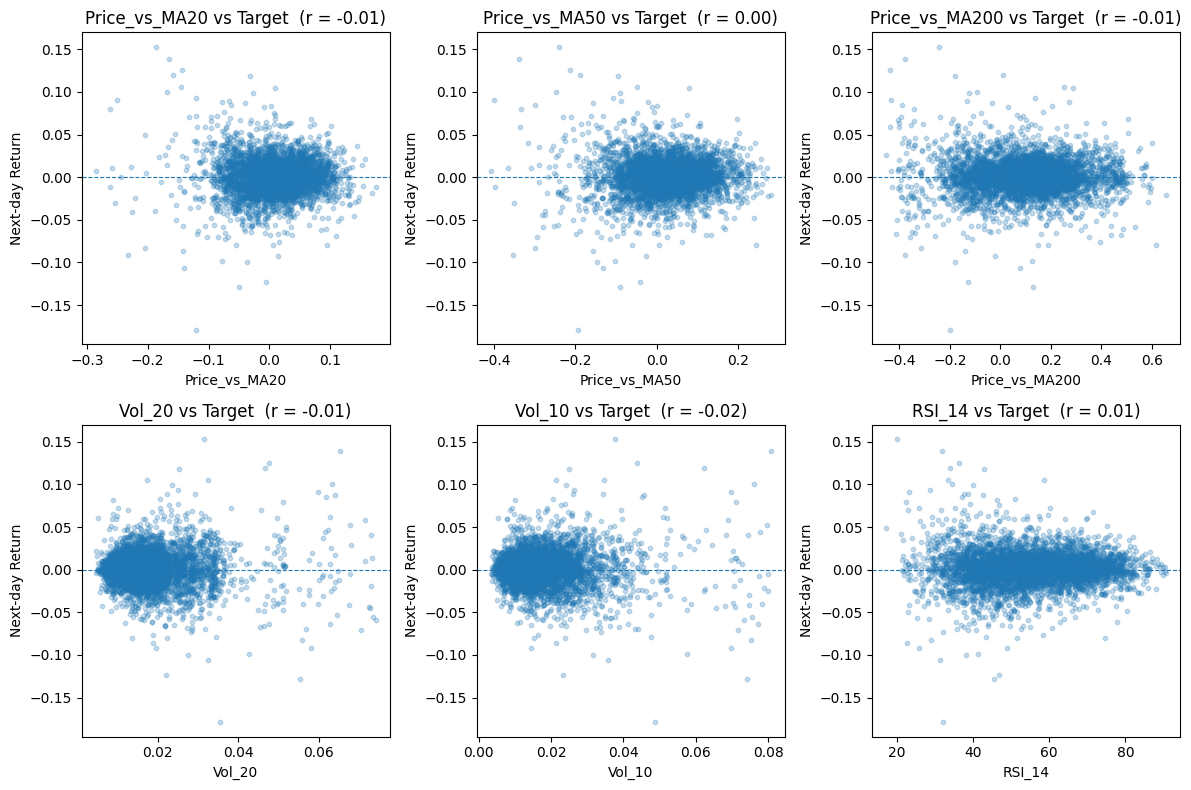

In [40]:
# ---------- SCATTER: top features vs next-day target (safe & dynamic) ----------

# 0) Sanity: make sure df_feat and TARGET exist
assert "df_feat" in globals() and TARGET in df_feat.columns, "Run feature engineering first."

# 1) Pick candidate features and keep only those present
candidates = [
    "Price_vs_MA20", "Price_vs_MA50", "Price_vs_MA200",
    "Vol_20", "Vol_10",
    "RSI_14", "MACD_Hist",
    "Return_1d_lag1", "Return_1d_lag2",
    "BB_PctB_20_2", "BB_Width_20_2"
]
top_feats = [c for c in candidates if c in df_feat.columns]

# if you want to cap to exactly 6 plots, keep the first 6 present:
top_feats = top_feats[:6]

if not top_feats:
    raise ValueError("No plotting features found. Check that your feature names match df_feat columns.")

# 2) Build subplots grid sized to number of features
import math
n = len(top_feats)
rows = 2
cols = 3 if n > 3 else n  # 1–3 features -> 1 row; 4–6 -> 2 rows
fig, axes = plt.subplots(rows if n > 3 else 1, cols, figsize=(12, 4 if n <= 3 else 8))
axes = np.atleast_1d(axes).ravel()

# 3) Scatter each feature vs TARGET with small alpha; add Pearson r
y = df_feat[TARGET].values
for ax, col in zip(axes, top_feats):
    x = df_feat[col].values
    # compute Pearson r safely
    valid = ~np.isnan(x) & ~np.isnan(y)
    if valid.sum() > 1:
        r = np.corrcoef(x[valid], y[valid])[0, 1]
    else:
        r = np.nan
    ax.scatter(x, y, alpha=0.25, s=10)
    ax.axhline(0, linestyle="--", linewidth=0.8)
    ax.set_xlabel(col)
    ax.set_ylabel("Next-day Return")
    ax.set_title(f"{col} vs Target  (r = {r:.2f})")

# Hide any unused axes
for j in range(len(top_feats), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [41]:
# ---------- 10) TRAIN / TEST SPLIT (TIME-BASED, NO SHUFFLE) ----------
X = df_feat[features]
y = df_feat[TARGET]

# choose your split date above; ensure it's within the index range
train_mask = X.index < pd.to_datetime(test_start_date)
X_train, y_train = X[train_mask], y[train_mask]
X_test,  y_test  = X[~train_mask], y[~train_mask]

print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)
print("Train window:", X_train.index.min().date(), "→", X_train.index.max().date())
print("Test  window:", X_test.index.min().date(),  "→", X_test.index.max().date())



Train shape: (4480, 10) | Test shape: (469, 10)
Train window: 2006-03-15 → 2023-12-29
Test  window: 2024-01-02 → 2025-11-12


In [42]:
# ---------- SAFE BUILD: classification target + features + split ----------

# 0) Make sure columns are flat (yfinance sometimes returns MultiIndex)
if isinstance(df_feat.columns, pd.MultiIndex):
    df_feat.columns = [c[0] if isinstance(c, tuple) else c for c in df_feat.columns]

# 1) Ensure core columns exist
if "Return_1d" not in df_feat.columns:
    df_feat["Return_1d"] = df_feat["Close"].pct_change()

# If your regression target wasn't created in this session, recreate it
if "Target_Return_1d" not in df_feat.columns:
    df_feat["Target_Return_1d"] = df_feat["Return_1d"].shift(-1)

# 2) Create (or recreate) the classification label
df_feat["Target_Up"] = (df_feat["Target_Return_1d"] > 0).astype(int)

# 3) Feature list (start from your regression set; add extras if present)
features_cls = [
    "Return_1d","LogReturn_1d","ROC_5","ROC_20","Ret_Z_20",
    "MA_5","MA_10","MA_20","MA_50","MA_200","EMA_12","EMA_26",
    "Price_vs_MA20","Price_vs_MA50","MA_Ratio_5_20","MA_Ratio_20_50","EMA_Spread_12_26",
    "Vol_10","Vol_20","Vol_60","RealizedVol_20_ann",
    "RSI_14","MACD","MACD_Signal","MACD_Hist","BB_PctB_20_2","BB_Width_20_2",
    "Return_1d_lag1","Return_1d_lag2","Return_1d_lag3","Return_1d_lag5","Return_1d_lag10",
    # optional extras (only keep if they exist)
    "Stoch_%K","Stoch_%D","Williams_%R","OBV","DOW_sin","DOW_cos","Month_sin","Month_cos"
]
features_cls = [f for f in features_cls if f in df_feat.columns]

# 4) Clean only the columns we will use (keeps X and y aligned)
used_cols = features_cls + ["Target_Up"]
df_cls = df_feat[used_cols].dropna().copy()

# 5) Build X, y and time-based split
Xc = df_cls[features_cls].copy()
yc = df_cls["Target_Up"].copy()

train_mask = Xc.index < pd.to_datetime(test_start_date)
Xc_train, yc_train = Xc[train_mask], yc[train_mask]
Xc_test,  yc_test  = Xc[~train_mask], yc[~train_mask]

print("CLS Train/Test:", Xc_train.shape, Xc_test.shape,
      "| Up-rate test:", float(yc_test.mean()))


CLS Train/Test: (4480, 14) (469, 14) | Up-rate test: 0.5479744136460555


In [43]:
# ---------- 11) BASELINES ----------
# Use NumPy for RMSE calculation
def rmse(y_true, y_pred):
    """Root Mean Squared Error using NumPy."""
    return np.sqrt(np.mean((np.asarray(y_true) - np.asarray(y_pred)) ** 2))

# Baseline 1: persistence — predict tomorrow's return = today's return
baseline_pred = X_test["Return_1d"].values
baseline_rmse = rmse(y_test, baseline_pred)

# Baseline 2: simple mean of last few returns (lag1–3)
baseline_ma = X_test[["Return_1d","Return_1d_lag1","Return_1d_lag2"]].mean(axis=1).values
baseline_ma_rmse = rmse(y_test, baseline_ma)

print(f"Baseline (persistence) RMSE : {baseline_rmse:.6f}")
print(f"Baseline (lag1-3 mean) RMSE : {baseline_ma_rmse:.6f}")


Baseline (persistence) RMSE : 0.024947
Baseline (lag1-3 mean) RMSE : 0.020951


In [44]:
# ---------- 12) LINEAR REGRESSION ----------
lin = LinearRegression()
lin.fit(X_train, y_train)

lin_pred = lin.predict(X_test)
lin_rmse = rmse(y_test, lin_pred)
lin_r2   = r2_score(y_test, lin_pred)

print(f"Linear Regression — RMSE: {lin_rmse:.6f} | R²: {lin_r2:.4f}")


Linear Regression — RMSE: 0.018001 | R²: 0.0004


In [45]:
xgb = XGBClassifier(
    n_estimators=600,
    learning_rate=0.03,
    max_depth=3,           # shallower = more generalizable
    min_child_weight=5,    # regularization
    subsample=0.8,
    colsample_bytree=0.5,  # random feature subsampling
    reg_lambda=2.0,
    random_state=SEED,
    eval_metric="logloss",
    n_jobs=-1
)
xgb.fit(Xc_train, yc_train)

proba_test = xgb.predict_proba(Xc_test)[:, 1]
pred_test = (proba_test >= 0.5).astype(int)

print(f"Accuracy: {accuracy_score(yc_test, pred_test):.3f}")
print(f"ROC-AUC:  {roc_auc_score(yc_test, proba_test):.3f}")


print(f"XGB — Accuracy: {accuracy_score(yc_test, pred_test):.3f} | ROC-AUC: {roc_auc_score(yc_test, proba_test):.3f}")
print("Confusion matrix:\n", confusion_matrix(yc_test, pred_test))
print(classification_report(yc_test, pred_test, digits=3))


Accuracy: 0.475
ROC-AUC:  0.460
XGB — Accuracy: 0.475 | ROC-AUC: 0.460
Confusion matrix:
 [[ 78 134]
 [112 145]]
              precision    recall  f1-score   support

           0      0.411     0.368     0.388       212
           1      0.520     0.564     0.541       257

    accuracy                          0.475       469
   macro avg      0.465     0.466     0.465       469
weighted avg      0.470     0.475     0.472       469



In [46]:
# ---------- 13) RANDOM FOREST + RANDOMIZED SEARCH (SMALL) ----------
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

tscv = TimeSeriesSplit(n_splits=3)  # fewer splits to speed up

rf = RandomForestRegressor(random_state=SEED, n_jobs=-1)

param_dist = {
    "n_estimators": randint(150, 401),     # 150–400
    "max_depth": [None, 6, 10, 14],
    "min_samples_leaf": randint(1, 5),     # 1–4
    "max_features": ["sqrt", "log2", 0.7], # try smaller feature subsampling
}

rsearch = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=12,              # small budget
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    random_state=SEED,
    verbose=0
)
rsearch.fit(X_train, y_train)

best_rf = rsearch.best_estimator_
print("Best RF params:", rsearch.best_params_)

rf_pred = best_rf.predict(X_test)
rf_rmse = rmse(y_test, rf_pred)
rf_r2   = r2_score(y_test, rf_pred)
print(f"Random Forest — RMSE: {rf_rmse:.6f} | R²: {rf_r2:.4f}")


Best RF params: {'max_depth': 6, 'max_features': 0.7, 'min_samples_leaf': 3, 'n_estimators': 224}
Random Forest — RMSE: 0.017995 | R²: 0.0010


In [47]:
# --- choose threshold on last 20% of training period ---
split_idx = int(len(Xc_train)*0.8)
Xtr, Xva = Xc_train.iloc[:split_idx], Xc_train.iloc[split_idx:]
ytr, yva = yc_train.iloc[:split_idx], yc_train.iloc[split_idx:]

xgb.fit(Xtr, ytr)
proba_val = xgb.predict_proba(Xva)[:, 1]

ths = np.linspace(0.45, 0.60, 16)
best_t, best_acc = 0.50, 0.0
for t in ths:
    acc_t = accuracy_score(yva, (proba_val >= t).astype(int))
    if acc_t > best_acc:
        best_t, best_acc = t, acc_t

print(f"Chosen threshold: {best_t:.3f} (val acc={best_acc:.3f})")

# refit on full training and evaluate on test
xgb.fit(Xc_train, yc_train)
proba_test = xgb.predict_proba(Xc_test)[:, 1]
pred_test  = (proba_test >= best_t).astype(int)

print(f"Test Accuracy (t={best_t:.3f}): {accuracy_score(yc_test, pred_test):.3f}")
print(f"Test ROC-AUC: {roc_auc_score(yc_test, proba_test):.3f}")


Chosen threshold: 0.450 (val acc=0.526)
Test Accuracy (t=0.450): 0.525
Test ROC-AUC: 0.460


In [48]:
# ---------- 14) METRICS SUMMARY ----------
def directional_accuracy(y_true, y_pred):
    """Share of predictions with correct sign (direction)."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return float(np.mean(np.sign(y_true) == np.sign(y_pred)))

def mape_safe(y_true, y_pred, eps=1e-8):
    """Stable MAPE for small or zero returns."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return float(np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))))

metrics_test = {
    "baseline_persistence_rmse": float(baseline_rmse),
    "baseline_lagmean_rmse": float(baseline_ma_rmse),
    "linear_rmse": float(lin_rmse),
    "linear_r2": float(lin_r2),
    "rf_rmse": float(rf_rmse),
    "rf_r2": float(rf_r2),
    "linear_dir_acc": directional_accuracy(y_test, lin_pred),
    "rf_dir_acc": directional_accuracy(y_test, rf_pred),
    "linear_mape": mape_safe(y_test.values, lin_pred),
    "rf_mape": mape_safe(y_test.values, rf_pred),
}
metrics_test


{'baseline_persistence_rmse': 0.024947255634727467,
 'baseline_lagmean_rmse': 0.020950846387107067,
 'linear_rmse': 0.018000809742425097,
 'linear_r2': 0.00035686822100533533,
 'rf_rmse': 0.017995110569245635,
 'rf_r2': 0.000989755022380856,
 'linear_dir_acc': 0.4989339019189765,
 'rf_dir_acc': 0.5373134328358209,
 'linear_mape': 124.62497209782504,
 'rf_mape': 80.13273078059616}

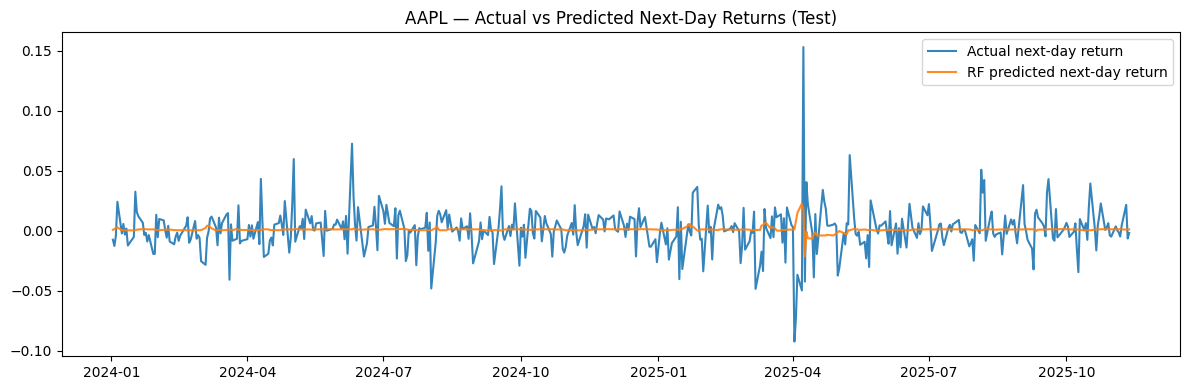

In [49]:
# ---------- 15) PLOT: ACTUAL vs PREDICTED RETURNS ----------
plt.figure(figsize=(12,4))
plt.plot(y_test.index, y_test.values, label="Actual next-day return", alpha=0.9)
plt.plot(y_test.index, rf_pred,        label="RF predicted next-day return", alpha=0.9)
plt.title(f"{symbol} — Actual vs Predicted Next-Day Returns (Test)")
plt.legend()
plt.tight_layout()
plt.show()

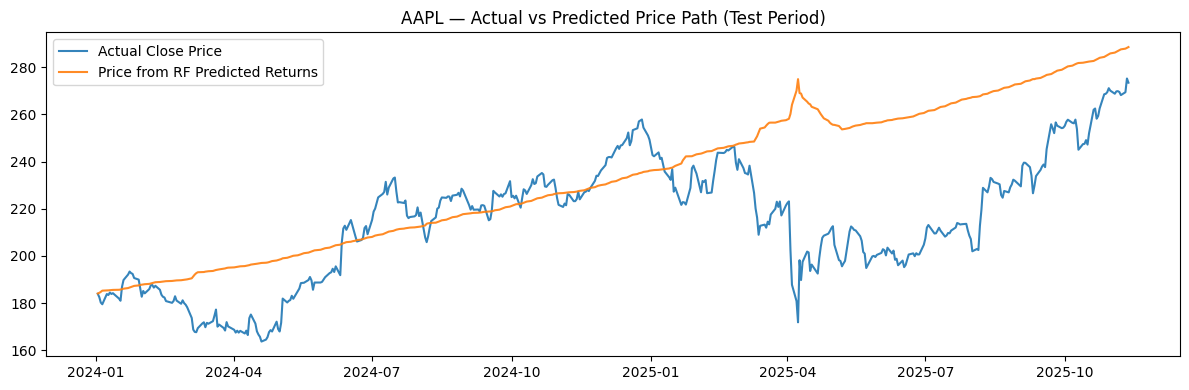

In [50]:
# ---------- 16) RETURNS → PRICE PATH (Close) ----------
# Rebuild a hypothetical price series from predicted returns for intuition
test_close = df.loc[y_test.index, "Close"].copy()

def apply_returns(p0, rets):
    """Cumulative price reconstruction from predicted returns."""
    path = [p0]
    for r in rets:
        path.append(path[-1] * (1 + r))
    return np.array(path[1:])

rf_price_path = apply_returns(test_close.iloc[0], rf_pred)

plt.figure(figsize=(12,4))
plt.plot(test_close.index, test_close.values, label="Actual Close Price", alpha=0.9)
plt.plot(test_close.index, rf_price_path,      label="Price from RF Predicted Returns", alpha=0.9)
plt.title(f"{symbol} — Actual vs Predicted Price Path (Test Period)")
plt.legend()
plt.tight_layout()
plt.show()


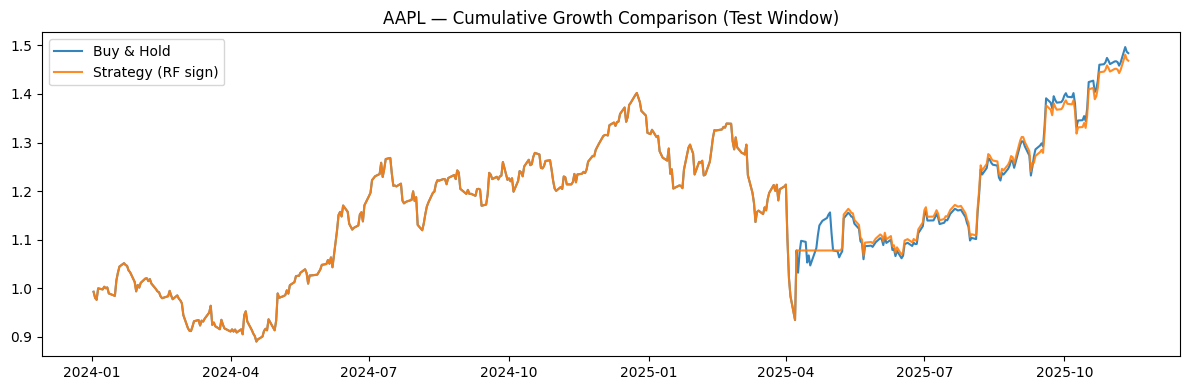

Directional accuracy (RF): 53.73%


In [51]:
# ---------- 17) TOY STRATEGY BACKTEST ----------
# Long if predicted next-day return > 0; flat otherwise (no shorting/costs)
position = (rf_pred > 0).astype(int)
strategy_returns = position * y_test.values
bh_returns = y_test.values  # Buy & Hold baseline

cum_bh = np.cumprod(1 + bh_returns)
cum_strategy = np.cumprod(1 + strategy_returns)

plt.figure(figsize=(12,4))
plt.plot(y_test.index, cum_bh, label="Buy & Hold", alpha=0.9)
plt.plot(y_test.index, cum_strategy, label="Strategy (RF sign)", alpha=0.9)
plt.title(f"{symbol} — Cumulative Growth Comparison (Test Window)")
plt.legend()
plt.tight_layout()
plt.show()

print("Directional accuracy (RF):", f"{metrics_test['rf_dir_acc']:.2%}")


Price_vs_MA20     1.082111e-02
Return_1d_lag2    4.749046e-03
Return_1d_lag1    1.836411e-03
MA_20             3.330669e-17
Vol_20           -3.506293e-04
BB_PctB_20_2     -1.583784e-03
Return_1d        -3.206268e-03
MACD_Hist        -4.567409e-03
RSI_14           -8.969841e-03
BB_Width_20_2    -9.231137e-03
dtype: float64

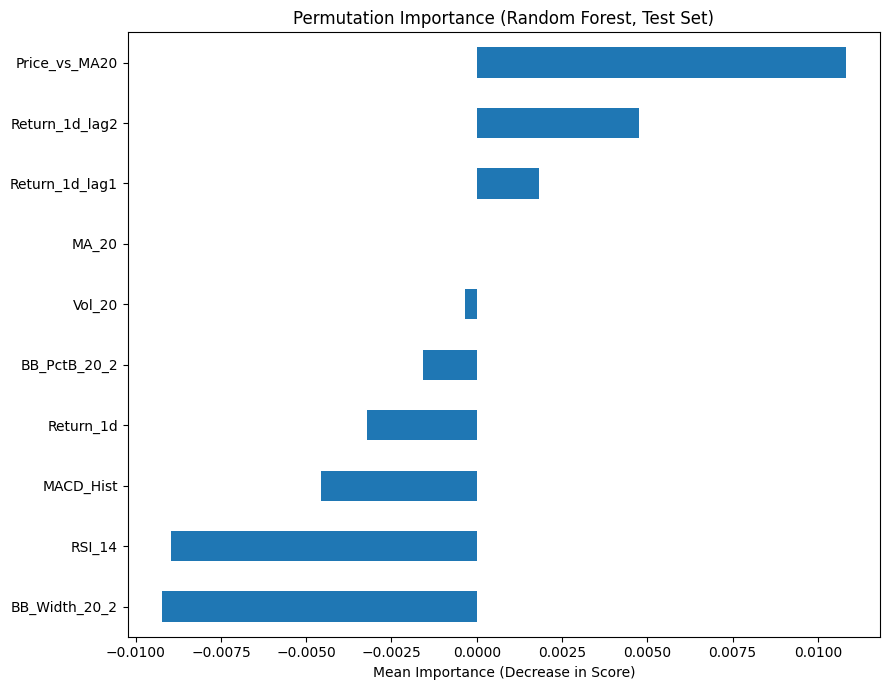

In [52]:
# ---------- 18) FEATURE IMPORTANCE (PERMUTATION) ----------
# Permutation importance = performance drop when a feature is randomly shuffled
perm = permutation_importance(best_rf, X_test, y_test, n_repeats=10, random_state=SEED, n_jobs=-1)
imp = pd.Series(perm.importances_mean, index=features).sort_values(ascending=False)

display(imp.head(15))

plt.figure(figsize=(9,7))
imp.head(20).sort_values().plot(kind="barh")
plt.title("Permutation Importance (Random Forest, Test Set)")
plt.xlabel("Mean Importance (Decrease in Score)")
plt.tight_layout()
plt.show()


In [53]:
# ---------- 19) WALK-FORWARD VALIDATION (OPTIONAL) ----------
def walk_forward_rmse(X, y, splits=5):
    """Expanding-window validation to assess temporal robustness."""
    tscv = TimeSeriesSplit(n_splits=splits)
    rmses = []
    for fold, (tr_idx, va_idx) in enumerate(tscv.split(X, y), 1):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
        model = RandomForestRegressor(
            n_estimators=300, min_samples_leaf=2, random_state=SEED, n_jobs=-1
        )
        model.fit(X_tr, y_tr)
        pred_va = model.predict(X_va)
        fold_rmse = np.sqrt(np.mean((y_va - pred_va) ** 2))
        rmses.append(fold_rmse)
        print(f"Fold {fold}: RMSE = {fold_rmse:.6f}")
    return rmses

wf_rmses = walk_forward_rmse(X_train, y_train, splits=5)
print("Walk-forward average RMSE:", np.mean(wf_rmses))


Fold 1: RMSE = 0.023747
Fold 2: RMSE = 0.018701
Fold 3: RMSE = 0.014856
Fold 4: RMSE = 0.022787
Fold 5: RMSE = 0.018164
Walk-forward average RMSE: 0.01965089527740744
